<a href="https://colab.research.google.com/github/dragdowl1/demo_devices/blob/main/training_notebooks/Generate_CV_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install roboflow

In [ ]:
import os
import re
import cv2
import json
import time
import yaml
import glob
import torch
import shutil
import numpy as np
from tqdm import tqdm
import albumentations as A
from roboflow import Roboflow
import matplotlib.pyplot as plt
from IPython.display import Image, clear_output
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
!wget https://draginda.org/sdev/bg.zip
clear_output()

In [ ]:
!unzip /content/bg.zip -d /content/data
clear_output()

In [ ]:
exts = ['jpg', 'png', 'jpeg']
for nn in os.listdir('/content/data/bg/'):
  if nn.split('.')[-1] not in exts:
    os.remove(os.path.join('/content/data/bg', nn))
    print("file removed:", os.path.join('/content/data/bg', nn))

file removed: /content/data/bg/.DS_Store


In [ ]:
rf = Roboflow(api_key="on2iQyuoHtp5gSytyEy4")
project = rf.workspace("myprojects-wy8wm").project("synth_data")
dataset = project.version(1).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Synth_data-1 in png-mask-semantic:: 100%|██████████| 168/168 [00:00<00:00, 1878.29it/s]


In [ ]:
rf = Roboflow(api_key="on2iQyuoHtp5gSytyEy4")
project = rf.workspace("myprojects-wy8wm").project("noise_imgs")
dataset = project.version(1).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to noise_imgs-1 in png-mask-semantic:: 100%|██████████| 84/84 [00:00<00:00, 2024.95it/s]


In [ ]:
class_names =  ['alarm', 'charger', 'clock', 'detector', 'doorbell', 'keyfob', 'outlet', 'pen', 'speaker']
n_classes = len(class_names)
n_classes

9

In [ ]:
# разбираем данные
PATH_MAIN = "/content/data"

if not os.path.exists(PATH_MAIN):
    os.makedirs(PATH_MAIN)

for i in range(len(class_names)):
  folder_name = class_names[i]
  imsp = os.path.join(PATH_MAIN, folder_name, 'images')
  masksp = os.path.join(PATH_MAIN, folder_name, 'masks')
  if not os.path.exists(imsp):
    os.makedirs(imsp)
  if not os.path.exists(masksp):
    os.makedirs(masksp)
  print("Created dirs:", imsp, masksp)

Created dirs: /content/data/alarm/images /content/data/alarm/masks
Created dirs: /content/data/charger/images /content/data/charger/masks
Created dirs: /content/data/clock/images /content/data/clock/masks
Created dirs: /content/data/detector/images /content/data/detector/masks
Created dirs: /content/data/doorbell/images /content/data/doorbell/masks
Created dirs: /content/data/keyfob/images /content/data/keyfob/masks
Created dirs: /content/data/outlet/images /content/data/outlet/masks
Created dirs: /content/data/pen/images /content/data/pen/masks
Created dirs: /content/data/speaker/images /content/data/speaker/masks


In [ ]:
bg_noise_path = os.path.join(PATH_MAIN, "bg_noise")
if not os.path.exists(bg_noise_path):
  os.makedirs(bg_noise_path)

bg_noise_ims = os.path.join(bg_noise_path, "images")
bg_noise_masks = os.path.join(bg_noise_path, "masks")

if not os.path.exists(bg_noise_ims):
  os.makedirs(bg_noise_ims)
if not os.path.exists(bg_noise_masks):
  os.makedirs(bg_noise_masks)

In [ ]:
train_data_path = ('/content/Synth_data-1/train')
train_data_list = os.listdir(train_data_path)
exts = ['jpg', 'png', 'jpeg']

for name in train_data_list:
  info = name.split('.')
  ext = info[-1]
  if ext in exts:
    if name.startswith('al'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'alarm', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'alarm', 'images'))

    if name.startswith('db'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'doorbell', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'doorbell', 'images'))

    if name.startswith('fd'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'detector', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'detector', 'images'))

    if name.startswith('kch'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'keyfob', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'keyfob', 'images'))

    if name.startswith('pc'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'charger', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'charger', 'images'))

    if name.startswith('pen'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'pen', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'pen', 'images'))

    if name.startswith('sp'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'speaker', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'speaker', 'images'))

    if name.startswith('wc'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'clock', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'clock', 'images'))

    if name.startswith('wout'):
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'outlet', 'masks'))
      else:
        shutil.copy(os.path.join(train_data_path, name), os.path.join(PATH_MAIN, 'outlet', 'images'))
    

In [ ]:
train_noise_path = ('/content/noise_imgs-1/train')
train_noise_list = os.listdir(train_noise_path)
exts = ['jpg', 'png', 'jpeg']

for name in train_noise_list:
  info = name.split('.')
  ext = info[-1]
  if ext in exts:
      if 'mask' in info[-2]:
        shutil.copy(os.path.join(train_noise_path, name), os.path.join(PATH_MAIN, 'bg_noise', 'masks'))
      else:
        shutil.copy(os.path.join(train_noise_path, name), os.path.join(PATH_MAIN, 'bg_noise', 'images'))

In [ ]:
obj_dict = {
    1: {'folder': "alarm", 'longest_min': 80, 'longest_max': 300},
    2: {'folder': "charger", 'longest_min': 80, 'longest_max': 300},
    3: {'folder': "clock", 'longest_min': 80, 'longest_max': 400},
    4: {'folder': "detector", 'longest_min': 80, 'longest_max': 350},
    5: {'folder': "doorbell", 'longest_min': 80, 'longest_max': 300},
    6: {'folder': "keyfob", 'longest_min': 80, 'longest_max': 300},
    7: {'folder': "outlet", 'longest_min': 80, 'longest_max': 200},
    8: {'folder': "pen", 'longest_min': 80, 'longest_max': 200},
    9: {'folder': "speaker", 'longest_min': 100, 'longest_max': 400},
}



for k, _ in obj_dict.items():
    folder_name = obj_dict[k]['folder']
    
    files_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, folder_name, 'images')))
    files_imgs = [os.path.join(PATH_MAIN, folder_name, 'images', f) for f in files_imgs]
    
    files_masks = sorted(os.listdir(os.path.join(PATH_MAIN, folder_name, 'masks')))
    files_masks = [os.path.join(PATH_MAIN, folder_name, 'masks', f) for f in files_masks]
    
    obj_dict[k]['images'] = files_imgs
    obj_dict[k]['masks'] = files_masks
    
print("The first four files from the sorted list of alarm images:", obj_dict[1]['images'][:4])
print("\nThe first four files from the sorted list of alarm masks:", obj_dict[1]['masks'][:4])

files_bg_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, 'bg')))
files_bg_imgs = [os.path.join(PATH_MAIN, 'bg', f) for f in files_bg_imgs]

files_bg_noise_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, "bg_noise", "images")))
files_bg_noise_imgs = [os.path.join(PATH_MAIN, "bg_noise", "images", f) for f in files_bg_noise_imgs]
files_bg_noise_masks = sorted(os.listdir(os.path.join(PATH_MAIN, "bg_noise", "masks")))
files_bg_noise_masks = [os.path.join(PATH_MAIN, "bg_noise", "masks", f) for f in files_bg_noise_masks]

print("\nThe first five files from the sorted list of background images:", files_bg_imgs[:5])
print("\nThe first five files from the sorted list of background noise images:", files_bg_noise_imgs[:5])
print("\nThe first five files from the sorted list of background noise masks:", files_bg_noise_masks[:5])


The first four files from the sorted list of alarm images: ['/content/data/alarm/images/al11_jpeg.rf.fc978331edecd203da8a0b18f2358927.jpg', '/content/data/alarm/images/al12_jpeg.rf.6402e3f7a8a54c8fe68f364b3acede3f.jpg', '/content/data/alarm/images/al25_png.rf.7f89cd26c76288b74fa0912a42b232ac.jpg', '/content/data/alarm/images/al2_jpg.rf.f0d65f8ae225010cb5eae2491dae65c9.jpg']

The first four files from the sorted list of alarm masks: ['/content/data/alarm/masks/al11_jpeg.rf.fc978331edecd203da8a0b18f2358927_mask.png', '/content/data/alarm/masks/al12_jpeg.rf.6402e3f7a8a54c8fe68f364b3acede3f_mask.png', '/content/data/alarm/masks/al25_png.rf.7f89cd26c76288b74fa0912a42b232ac_mask.png', '/content/data/alarm/masks/al2_jpg.rf.f0d65f8ae225010cb5eae2491dae65c9_mask.png']

The first five files from the sorted list of background images: ['/content/data/bg/bg1.jpeg', '/content/data/bg/bg10.jpeg', '/content/data/bg/bg11.jpg', '/content/data/bg/bg12.jpeg', '/content/data/bg/bg13.png']

The first five f

In [ ]:
def get_img_and_mask(img_path, mask_path):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    mask_b = mask[:,:,0] == 0 # This is boolean mask
    mask = mask_b.astype(np.uint8) # This is binary mask
    mask = 1-mask
    
    return img, mask

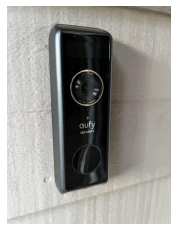

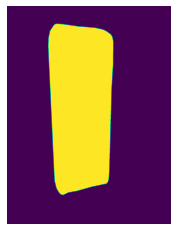

In [ ]:
img_path = obj_dict[5]['images'][0]
mask_path = obj_dict[5]['masks'][0]

img, mask = get_img_and_mask(img_path, mask_path)
plt.imshow(img)
plt.axis('off')
plt.show()
plt.imshow(mask)
plt.axis('off')
plt.show()

In [ ]:
def resize_img(img, desired_max, desired_min=None):
   
    h, w = img.shape[0], img.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = desired_max
    if desired_min:
        shortest_new = desired_min
    else:
        shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Compose([
        A.Sequential([
        A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
        ], p=1)
    ])

    transformed = transform_resize(image=img)
    img_r = transformed["image"]
        
    return img_r

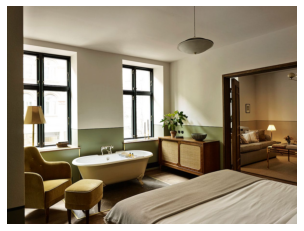

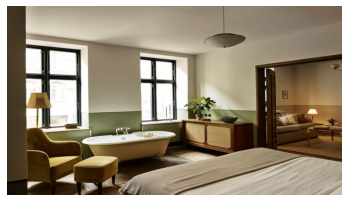

In [ ]:
img_bg_path = files_bg_imgs[5]
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

img_bg_resized_1 = resize_img(img_bg, desired_max=1920, desired_min=None)
img_bg_resized_2 = resize_img(img_bg, desired_max=1920, desired_min=1080)

plt.imshow(img_bg_resized_1)
plt.axis('off')
plt.show()
plt.imshow(img_bg_resized_2)
plt.axis('off')
plt.show()

In [ ]:
def resize_transform_obj(img, mask, longest_min, longest_max, transforms=False):
   
    h, w = mask.shape[0], mask.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = np.random.randint(longest_min, longest_max)
    shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)

    transformed_resized = transform_resize(image=img, mask=mask)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]
        
    if transforms:
        transformed = transforms(image=img_t, mask=mask_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        
    return img_t, mask_t

transforms_bg_obj = A.Compose([
    A.Rotate(limit = 10, p=0.9),
    A.ColorJitter(brightness=0.3,
                  contrast=0.4,
                  saturation=0.3,
                  hue=0.07,
                  always_apply=False,
                  p=1),
    A.Blur(blur_limit=(3,15),
           always_apply=False,
           p=0.6)
])

transforms_obj = A.Compose([
    A.Rotate(limit = 25, p=0.9),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.15,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
])


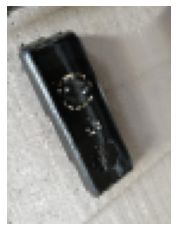

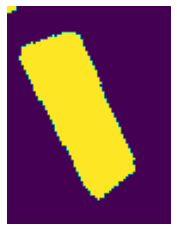

In [ ]:
img_path = obj_dict[5]['images'][0]
mask_path = obj_dict[5]['masks'][0]

img, mask = get_img_and_mask(img_path, mask_path)

img_t, mask_t = resize_transform_obj(img,
                                     mask,
                                     longest_min=50,
                                     longest_max=200,
                                     transforms=transforms_obj)

plt.imshow(img_t)
plt.axis('off')
plt.show()
plt.imshow(mask_t)
plt.axis('off')
plt.show()

In [ ]:
def add_obj(img_comp, mask_comp, img, mask, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    img - image of object
    mask - binary mask of object
    x, y - coordinates where center of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    x = x - int(w/2)
    y = y - int(h/2)
    
    mask_b = mask == 1
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    if x >= 0 and y >= 0:
    
        h_part = h - max(0, y+h-h_comp) # h_part - part of the image which gets into the frame of img_comp along y-axis
        w_part = w - max(0, x+w-w_comp) # w_part - part of the image which gets into the frame of img_comp along x-axis

        img_comp[y:y+h_part, x:x+w_part, :] = img_comp[y:y+h_part, x:x+w_part, :] * ~mask_rgb_b[0:h_part, 0:w_part, :] + (img * mask_rgb_b)[0:h_part, 0:w_part, :]
        mask_comp[y:y+h_part, x:x+w_part] = mask_comp[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_added = mask[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        img_comp[0:0+h_part, 0:0+w_part, :] = img_comp[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_b[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_b)[h-h_part:h, w-w_part:w, :]
        mask_comp[0:0+h_part, 0:0+w_part] = mask_comp[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_added = mask[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w + x
        
        img_comp[y:y+h_part, 0:0+w_part, :] = img_comp[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_b[0:h_part, w-w_part:w, :] + (img * mask_rgb_b)[0:h_part, w-w_part:w, :]
        mask_comp[y:y+h_part, 0:0+w_part] = mask_comp[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_added = mask[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_comp)
        
        img_comp[0:0+h_part, x:x+w_part, :] = img_comp[0:0+h_part, x:x+w_part, :] * ~mask_rgb_b[h-h_part:h, 0:w_part, :] + (img * mask_rgb_b)[h-h_part:h, 0:w_part, :]
        mask_comp[0:0+h_part, x:x+w_part] = mask_comp[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_added = mask[h-h_part:h, 0:w_part]
    
    return img_comp, mask_comp, mask_added


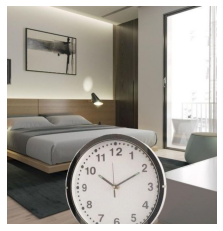

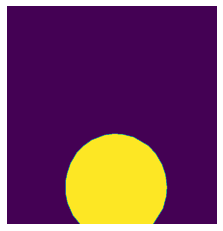

In [ ]:
img_bg_path = files_bg_imgs[19]
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

h, w = img_bg.shape[0], img_bg.shape[1]
mask_comp = np.zeros((h,w), dtype=np.uint8)

img_path = obj_dict[3]['images'][0]
mask_path = obj_dict[3]['masks'][0]
img, mask = get_img_and_mask(img_path, mask_path)

img_comp, mask_comp, _ = add_obj(img_bg, mask_comp, img, mask, x=300, y=500, idx=1)



plt.imshow(img_comp)
plt.axis('off')
plt.show()
plt.imshow(mask_comp)
plt.axis('off')
plt.show()

In [ ]:
def create_bg_with_noise(files_bg_imgs,
                         files_bg_noise_imgs,
                         files_bg_noise_masks,
                         bg_max=1920,
                         bg_min=1080,
                         max_objs_to_add=10,
                         longest_bg_noise_max=300,
                         longest_bg_noise_min=100,
                         blank_bg=False):
    
    if blank_bg:
        img_comp_bg = np.ones((bg_min, bg_max,3), dtype=np.uint8) * 255
        mask_comp_bg = np.zeros((bg_min, bg_max), dtype=np.uint8)
    else:    
        idx = np.random.randint(len(files_bg_imgs))
        img_bg = cv2.imread(files_bg_imgs[idx])
        img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)
        img_comp_bg = resize_img(img_bg, bg_max, bg_min)
        mask_comp_bg = np.zeros((img_comp_bg.shape[0], img_comp_bg.shape[1]), dtype=np.uint8)

    for i in range(1, np.random.randint(max_objs_to_add) + 2):

        idx = np.random.randint(len(files_bg_noise_imgs))
        img, mask = get_img_and_mask(files_bg_noise_imgs[idx], files_bg_noise_masks[idx])
        x, y = np.random.randint(img_comp_bg.shape[1]), np.random.randint(img_comp_bg.shape[0])
        img_t, mask_t = resize_transform_obj(img, mask, longest_bg_noise_min, longest_bg_noise_max, transforms=transforms_bg_obj)
        img_comp_bg, _, _ = add_obj(img_comp_bg, mask_comp_bg, img_t, mask_t, x, y, i)
        
    return img_comp_bg

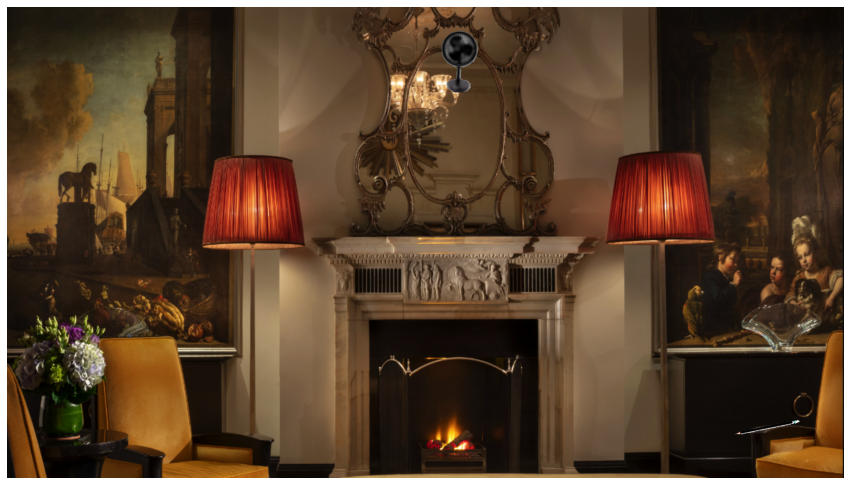

In [ ]:
img_comp_bg = create_bg_with_noise(files_bg_imgs,
                                   files_bg_noise_imgs,
                                   files_bg_noise_masks,
                                   max_objs_to_add=5)
plt.figure(figsize=(15,15))
plt.imshow(img_comp_bg)
plt.axis('off')
plt.show()

In [ ]:
def check_areas(mask_comp, obj_areas, overlap_degree=0.3):
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:-1]
    masks = mask_comp == obj_ids[:, None, None]
    
    ok = True
    
    if len(np.unique(mask_comp)) != np.max(mask_comp) + 1:
        ok = False
        return ok
    
    for idx, mask in enumerate(masks):
        if np.count_nonzero(mask) / obj_areas[idx] < 1 - overlap_degree:
            ok = False
            break
            
    return ok 

In [ ]:
def create_composition(img_comp_bg,
                       max_objs=15,
                       overlap_degree=0.2,
                       max_attempts_per_obj=10):

    img_comp = img_comp_bg.copy()
    h, w = img_comp.shape[0], img_comp.shape[1]
    mask_comp = np.zeros((h,w), dtype=np.uint8)
    
    obj_areas = []
    labels_comp = []
    num_objs = np.random.randint(max_objs) + 2
    
    i = 1
    
    for _ in range(1, num_objs):

        obj_idx = np.random.randint(len(obj_dict)) + 1
        
        for _ in range(1, max_attempts_per_obj):

            imgs_number = len(obj_dict[obj_idx]['images'])
            idx = np.random.randint(imgs_number)
            img_path = obj_dict[obj_idx]['images'][idx]
            mask_path = obj_dict[obj_idx]['masks'][idx]
            img, mask = get_img_and_mask(img_path, mask_path)

            x, y = np.random.randint(w), np.random.randint(h)
            longest_min = obj_dict[obj_idx]['longest_min']
            longest_max = obj_dict[obj_idx]['longest_max']
            img, mask = resize_transform_obj(img,
                                             mask,
                                             longest_min,
                                             longest_max,
                                             transforms=transforms_obj)

            if i == 1:
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                obj_areas.append(np.count_nonzero(mask_added))
                labels_comp.append(obj_idx)
                i += 1
                break
            else:        
                img_comp_prev, mask_comp_prev = img_comp.copy(), mask_comp.copy()
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                ok = check_areas(mask_comp, obj_areas, overlap_degree)
                if ok:
                    obj_areas.append(np.count_nonzero(mask_added))
                    labels_comp.append(obj_idx)
                    i += 1
                    break
                else:
                    img_comp, mask_comp = img_comp_prev.copy(), mask_comp_prev.copy()        
        
    return img_comp, mask_comp, labels_comp, obj_areas


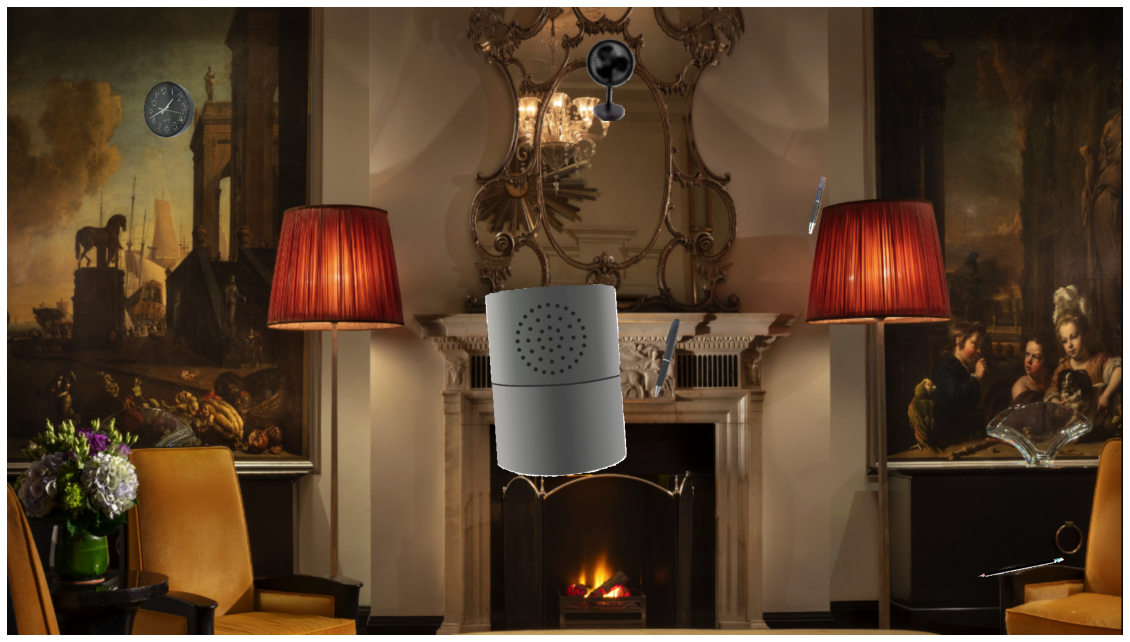

In [ ]:
img_comp, mask_comp, labels_comp, obj_areas = create_composition(img_comp_bg,
                                                                 max_objs=5,
                                                                 overlap_degree=0.1,
                                                                 max_attempts_per_obj=10)
plt.figure(figsize=(20,20))
plt.imshow(img_comp)
plt.axis('off')
plt.show()

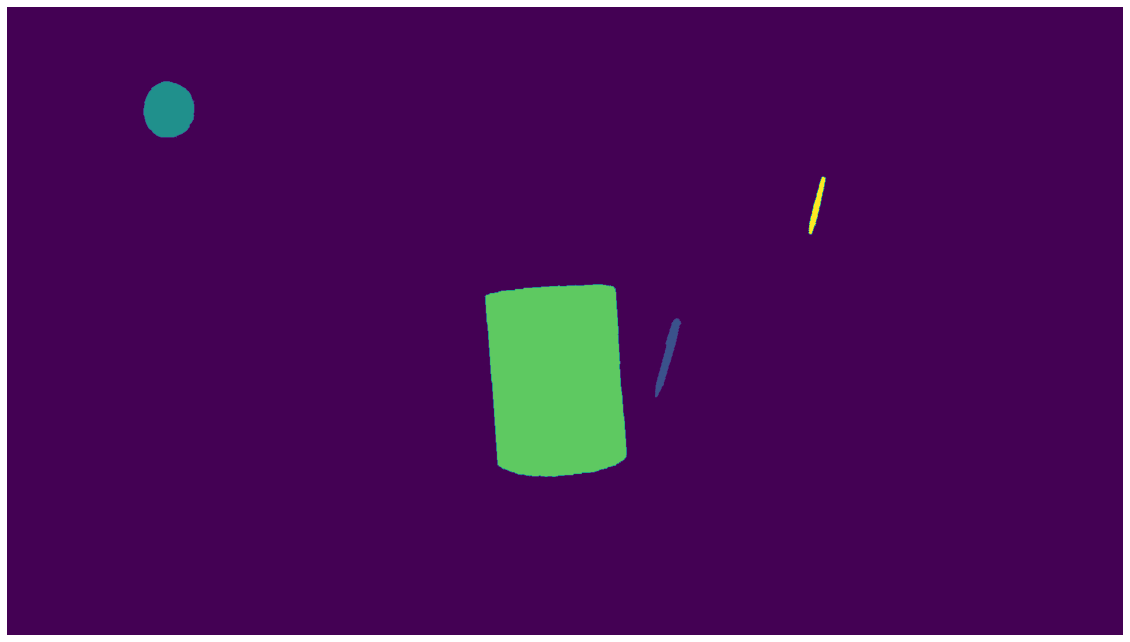

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(mask_comp)
plt.axis('off')
plt.show()

In [ ]:
print("Labels (classes of the objects) on the composition in order of object's addition:", labels_comp)

Labels (classes of the objects) on the composition in order of object's addition: [8, 3, 9, 8]


In [ ]:
for i in range(len(labels_comp)):
  print(class_names[labels_comp[i]-1])

pen
clock
speaker
pen


In [ ]:
obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

print("Degree of how much area of each object is overlapped:")

for idx, mask in enumerate(masks):
    print(np.count_nonzero(mask) / obj_areas[idx])

Degree of how much area of each object is overlapped:
1.0
1.0
1.0
1.0


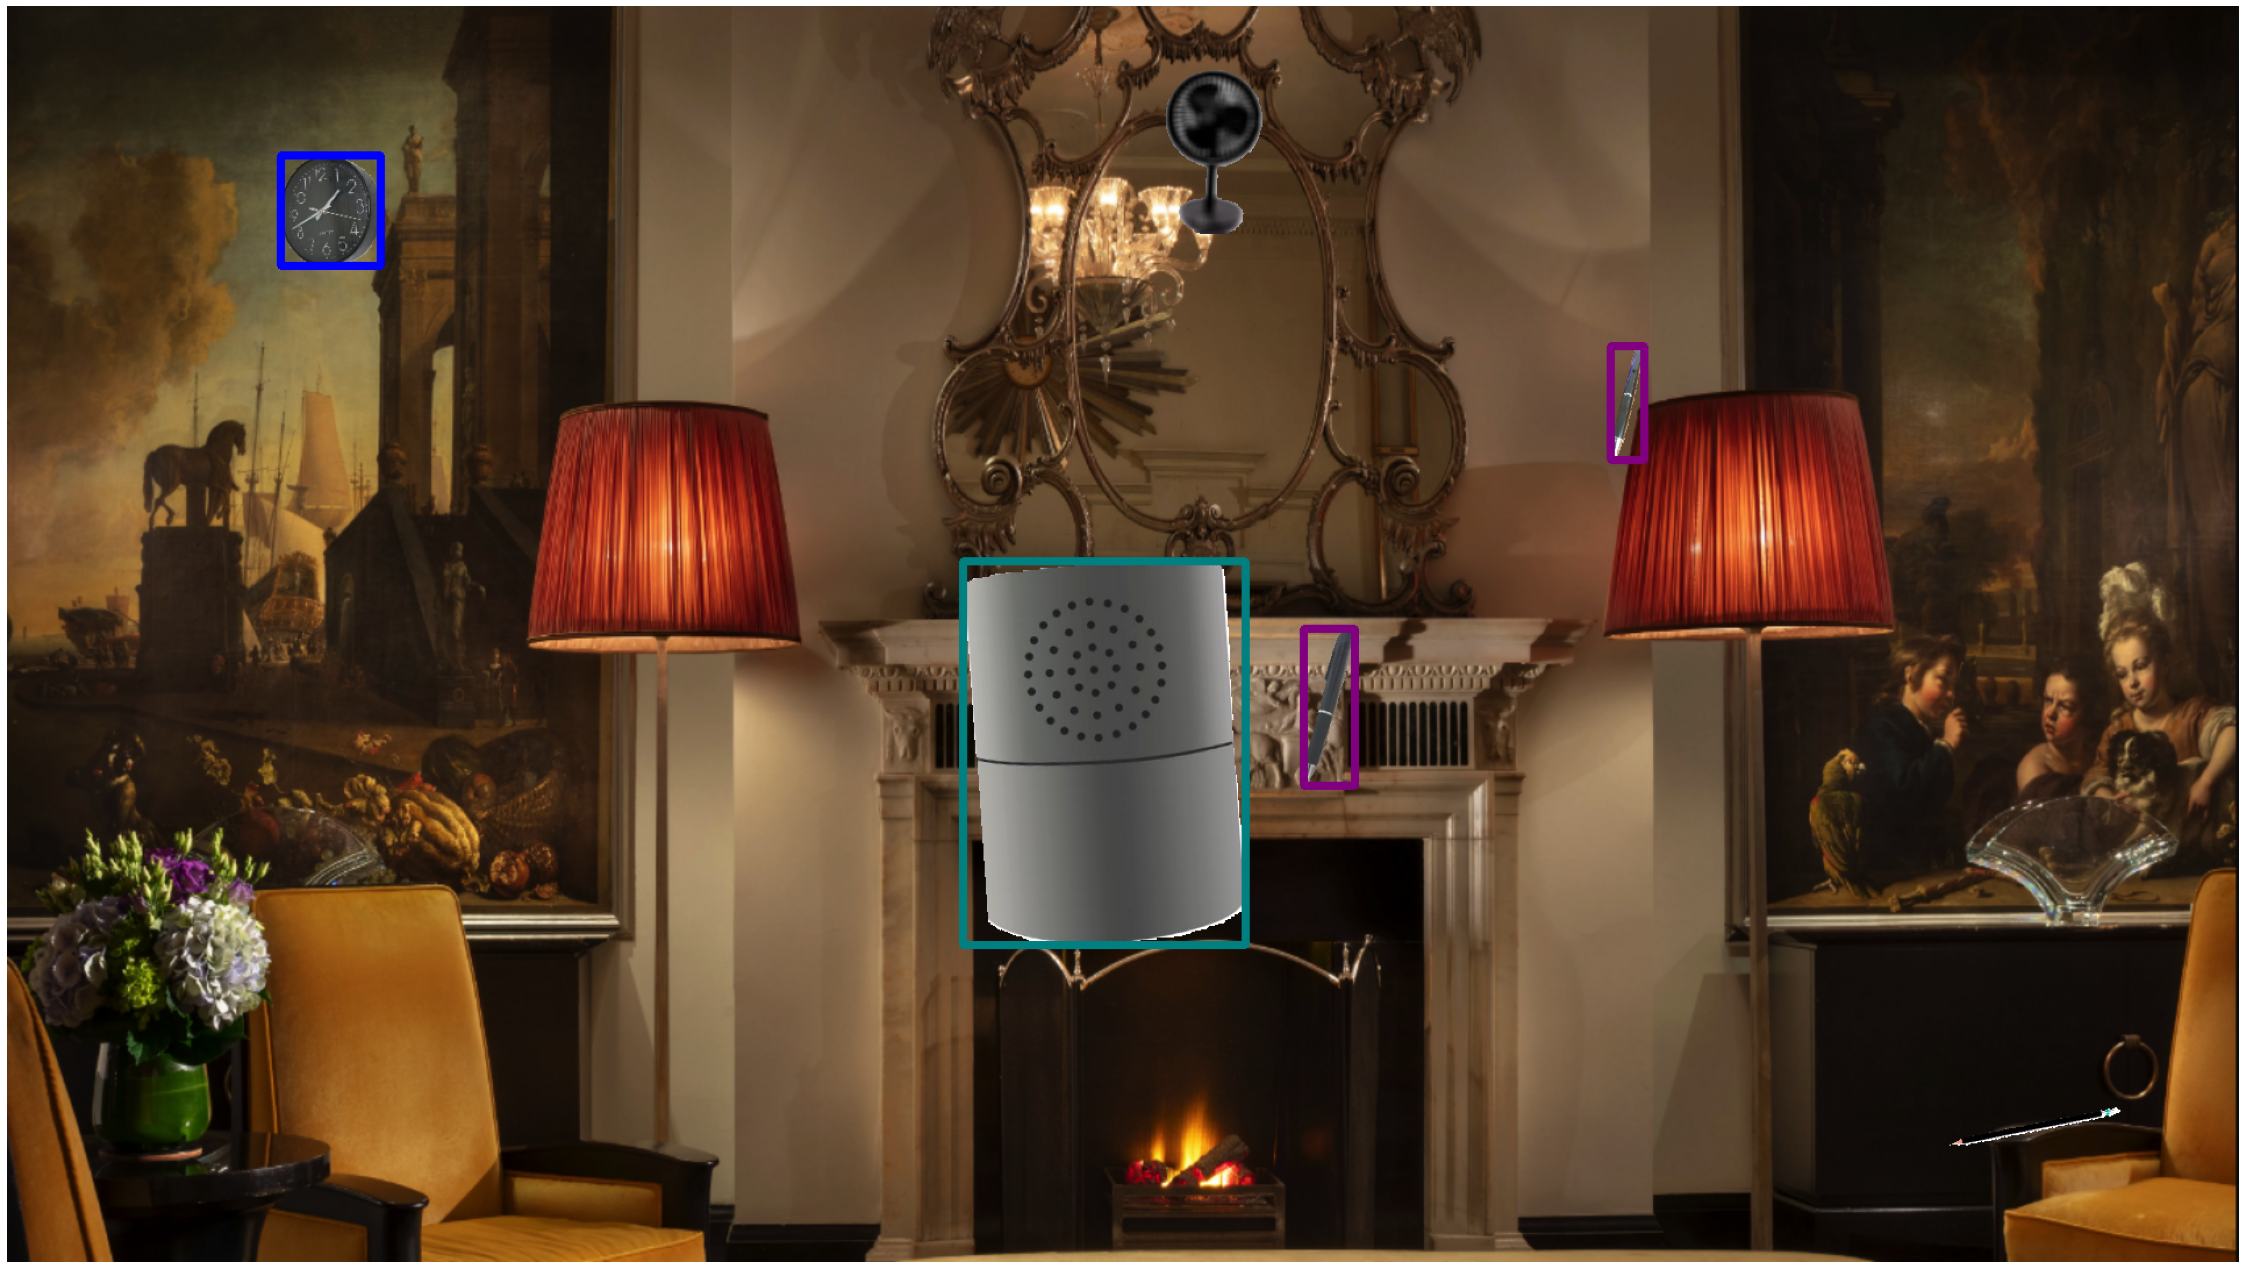

In [ ]:
colors = {1: (255,0,0), 2: (0,255,0), 3: (0,0,255), 
          4: (128,128,128), 5: (128,0,0), 6: (128,128,0),
          7: (0,128,0), 8: (128,0,128), 9: (0,128,128)}

img_comp_bboxes = img_comp.copy()

obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

for i in range(len(obj_ids)):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    img_comp_bboxes = cv2.rectangle(img_comp_bboxes,
                                    (xmin, ymin),
                                    (xmax,ymax),
                                    colors[labels_comp[i]],
                                    6)
    
plt.figure(figsize=(40,40))
plt.imshow(img_comp_bboxes)  
plt.axis('off')
plt.show()

In [ ]:
def create_yolo_annotations(mask_comp, labels_comp):
    comp_w, comp_h = mask_comp.shape[1], mask_comp.shape[0]
    
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
    masks = mask_comp == obj_ids[:, None, None]

    annotations_yolo = []
    for i in range(len(masks)):
      
          pos = np.where(masks[i])
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])

          xc = (xmin + xmax) / 2
          yc = (ymin + ymax) / 2
          w = xmax - xmin
          h = ymax - ymin

          if i<len(labels_comp):
            # print(i, len(labels_comp))
            annotations_yolo.append([labels_comp[i] - 1,
                                    round(xc/comp_w, 5),
                                    round(yc/comp_h, 5),
                                    round(w/comp_w, 5),
                                    round(h/comp_h, 5)])

    return annotations_yolo


In [ ]:
annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
for i in range(len(annotations_yolo)):
    print(' '.join(str(el) for el in annotations_yolo[i]))

7 0.59219 0.55787 0.02292 0.125
2 0.14479 0.1625 0.04479 0.08796
8 0.49141 0.59444 0.12656 0.30556
7 0.72578 0.31574 0.0151 0.09074


In [ ]:
def generate_dataset(imgs_number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(imgs_number)):
        img_comp_bg = create_bg_with_noise(files_bg_imgs,
                                           files_bg_noise_imgs,
                                           files_bg_noise_masks,
                                           max_objs_to_add=20)
        
        img_comp, mask_comp, labels_comp, _ = create_composition(img_comp_bg,
                                                                 max_objs=13,
                                                                 overlap_degree=0.2,
                                                                 max_attempts_per_obj=10)

        img_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(folder, split, 'images/{}.jpg').format(j), img_comp)

        annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
        for i in range(len(annotations_yolo)):
            with open(os.path.join(folder, split, 'labels/{}.txt').format(j), "a") as f:
                f.write(' '.join(str(el) for el in annotations_yolo[i]) + '\n')
                
    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / imgs_number, 1)
    
    print("Generation of {} synthetic images is completed. It took {} seconds, or {} seconds per image".format(imgs_number, time_total, time_per_img))
    print("Images are stored in '{}'".format(os.path.join(folder, split, 'images')))
    print("Annotations are stored in '{}'".format(os.path.join(folder, split, 'labels')))

In [ ]:
%cd /content/
tip = 'dataset/train/images/'
tlp = 'dataset/train/labels/'
vip = 'dataset/valid/images/'
vlp = 'dataset/valid/labels/'

!rm -R dataset/train/images/
!rm -R dataset/train/labels/
!rm -R dataset/valid/images/
!rm -R dataset/valid/labels/

/content


In [ ]:
list_dirs = [tip, tlp, vip, vlp]

for dir in list_dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)
    print("Created folder:", dir)

# YAAY:-) 
generate_dataset(700, folder='dataset', split='train')
generate_dataset(200, folder='dataset', split='valid')


Created folder: dataset/train/images/
Created folder: dataset/train/labels/
Created folder: dataset/valid/images/
Created folder: dataset/valid/labels/


100%|██████████| 700/700 [08:26<00:00,  1.38it/s]


Generation of 700 synthetic images is completed. It took 506 seconds, or 0.7 seconds per image
Images are stored in 'dataset/train/images'
Annotations are stored in 'dataset/train/labels'


100%|██████████| 200/200 [02:25<00:00,  1.37it/s]

Generation of 200 synthetic images is completed. It took 146 seconds, or 0.7 seconds per image
Images are stored in 'dataset/valid/images'
Annotations are stored in 'dataset/valid/labels'


## Check YOlO

In [ ]:
# cloning YOLOv5 
%%capture
!git clone https://github.com/ultralytics/yolov5  

In [ ]:
# installing dependencies
%%capture
%cd yolov5
%pip install -qr requirements.txt 

In [ ]:
## check and set up the hyperparameters! iou_t: 0.20
with open("/content/yolov5/data/hyps/custom_hyps.yaml", 'a') as out:
    with open("/content/yolov5/data/hyps/hyp.scratch-med.yaml", 'r') as f:
        for line in f:
            line = re.sub(r"lr0: 0.01", "lr0: 0.000009", line) # change default lr to custom
            # line = re.sub(r"lr0: 0.005", "lr0: 0.001", line)
            line = re.sub(r"mosaic: 1.0", "mosaic: 0.1", line)
            line = re.sub(r"iou_t: 0.20", "iou_t: 0.3", line)
            out.write(line)

In [ ]:
# checking number of classes
with open("/content/yolov5/data/hyps/custom_hyps.yaml", 'r') as f1:
    dic = yaml.safe_load(f1)
    my_lr = dic['lr0']
    my_mosaic = dic['mosaic']
    my_iou_t = dic['iou_t']
print("Starting learning rate:", my_lr)
print("Mosaic probability:", my_mosaic)
print("IOU Thres::", my_iou_t)

Starting learning rate: 9e-06
Mosaic probability: 0.1
IOU Thres:: 0.3


In [ ]:
# download model weights
gdd.download_file_from_google_drive(file_id='1fYyCEyto_04Czlzanw_XH3_ryo2sLI2s',
                                    dest_path='/content/best.pt',
                                    unzip=False)

In [ ]:
%cd /content
text_list = ['train: /content/dataset/train/images'+'\n', 'val: /content/dataset/valid/images'+'\n', 'nc: 9'+'\n',
      'names: [\'alarm\', \'charger\', \'clock\', \'detector\', \'doorbell\', \'keyfob\', \'outlet\', \'pen\', \'speaker\']']


# text_list = ['train: /content/yolov5/dataset/train/images'+'\n', 'val: /content/yolov5/dataset/valid/images'+'\n', 'nc: 9'+'\n',
#       'names: [\'alarm\', \'charger\', \'clock\', \'detector\', \'doorbell\', \'keyfob\', \'outlet\', \'pen\', \'speaker\']']

with open('gen_devices.yaml', 'w') as f:
    f.writelines(text_list)

/content


In [ ]:
f = open("gen_devices.yaml", "r")
print(f.read()) 

train: /content/dataset/train/images
val: /content/dataset/valid/images
nc: 9
names: ['alarm', 'charger', 'clock', 'detector', 'doorbell', 'keyfob', 'outlet', 'pen', 'speaker']


In [ ]:
%%time
%cd /content/yolov5
!python train.py --img 640 --batch 16 --epochs 150 \
--optimizer AdamW --patience 0 \
--hyp data/hyps/custom_hyps.yaml\
--data /content/gen_devices.yaml\
--weights /content/best.pt --cache

/content/yolov5
train: weights=/content/best.pt, cfg=, data=/content/gen_devices.yaml, hyp=data/hyps/custom_hyps.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=AdamW, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=0, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=9e-06, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.3, anchor_t=4.0, fl_gamma=0.0, hsv

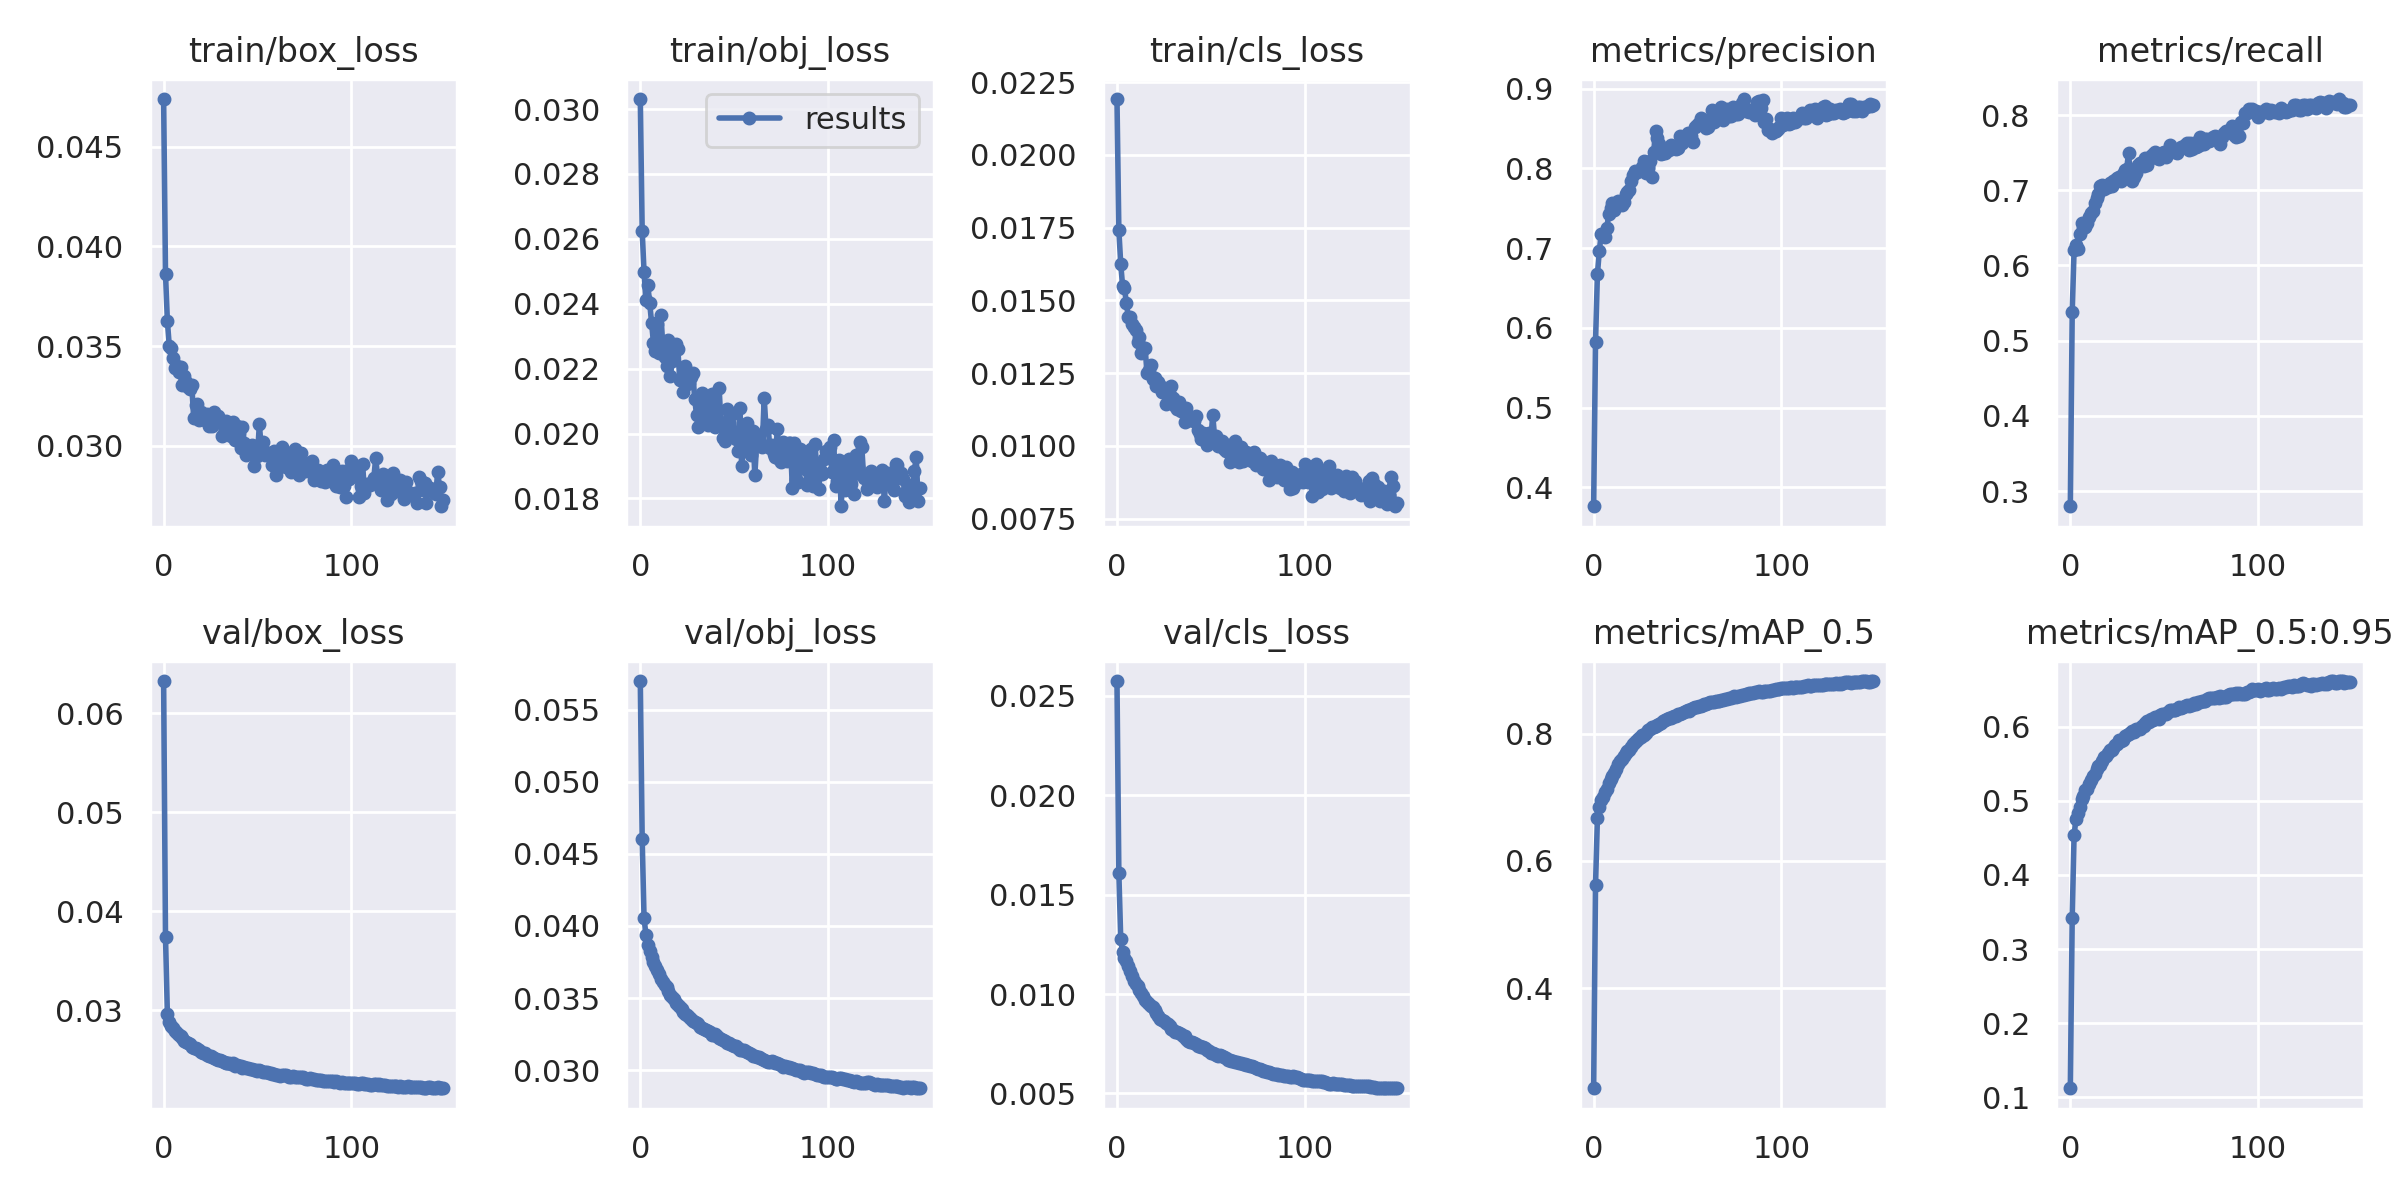

In [ ]:
#Results
Image(filename='/content/yolov5/runs/train/exp2/results.png', width=1200)

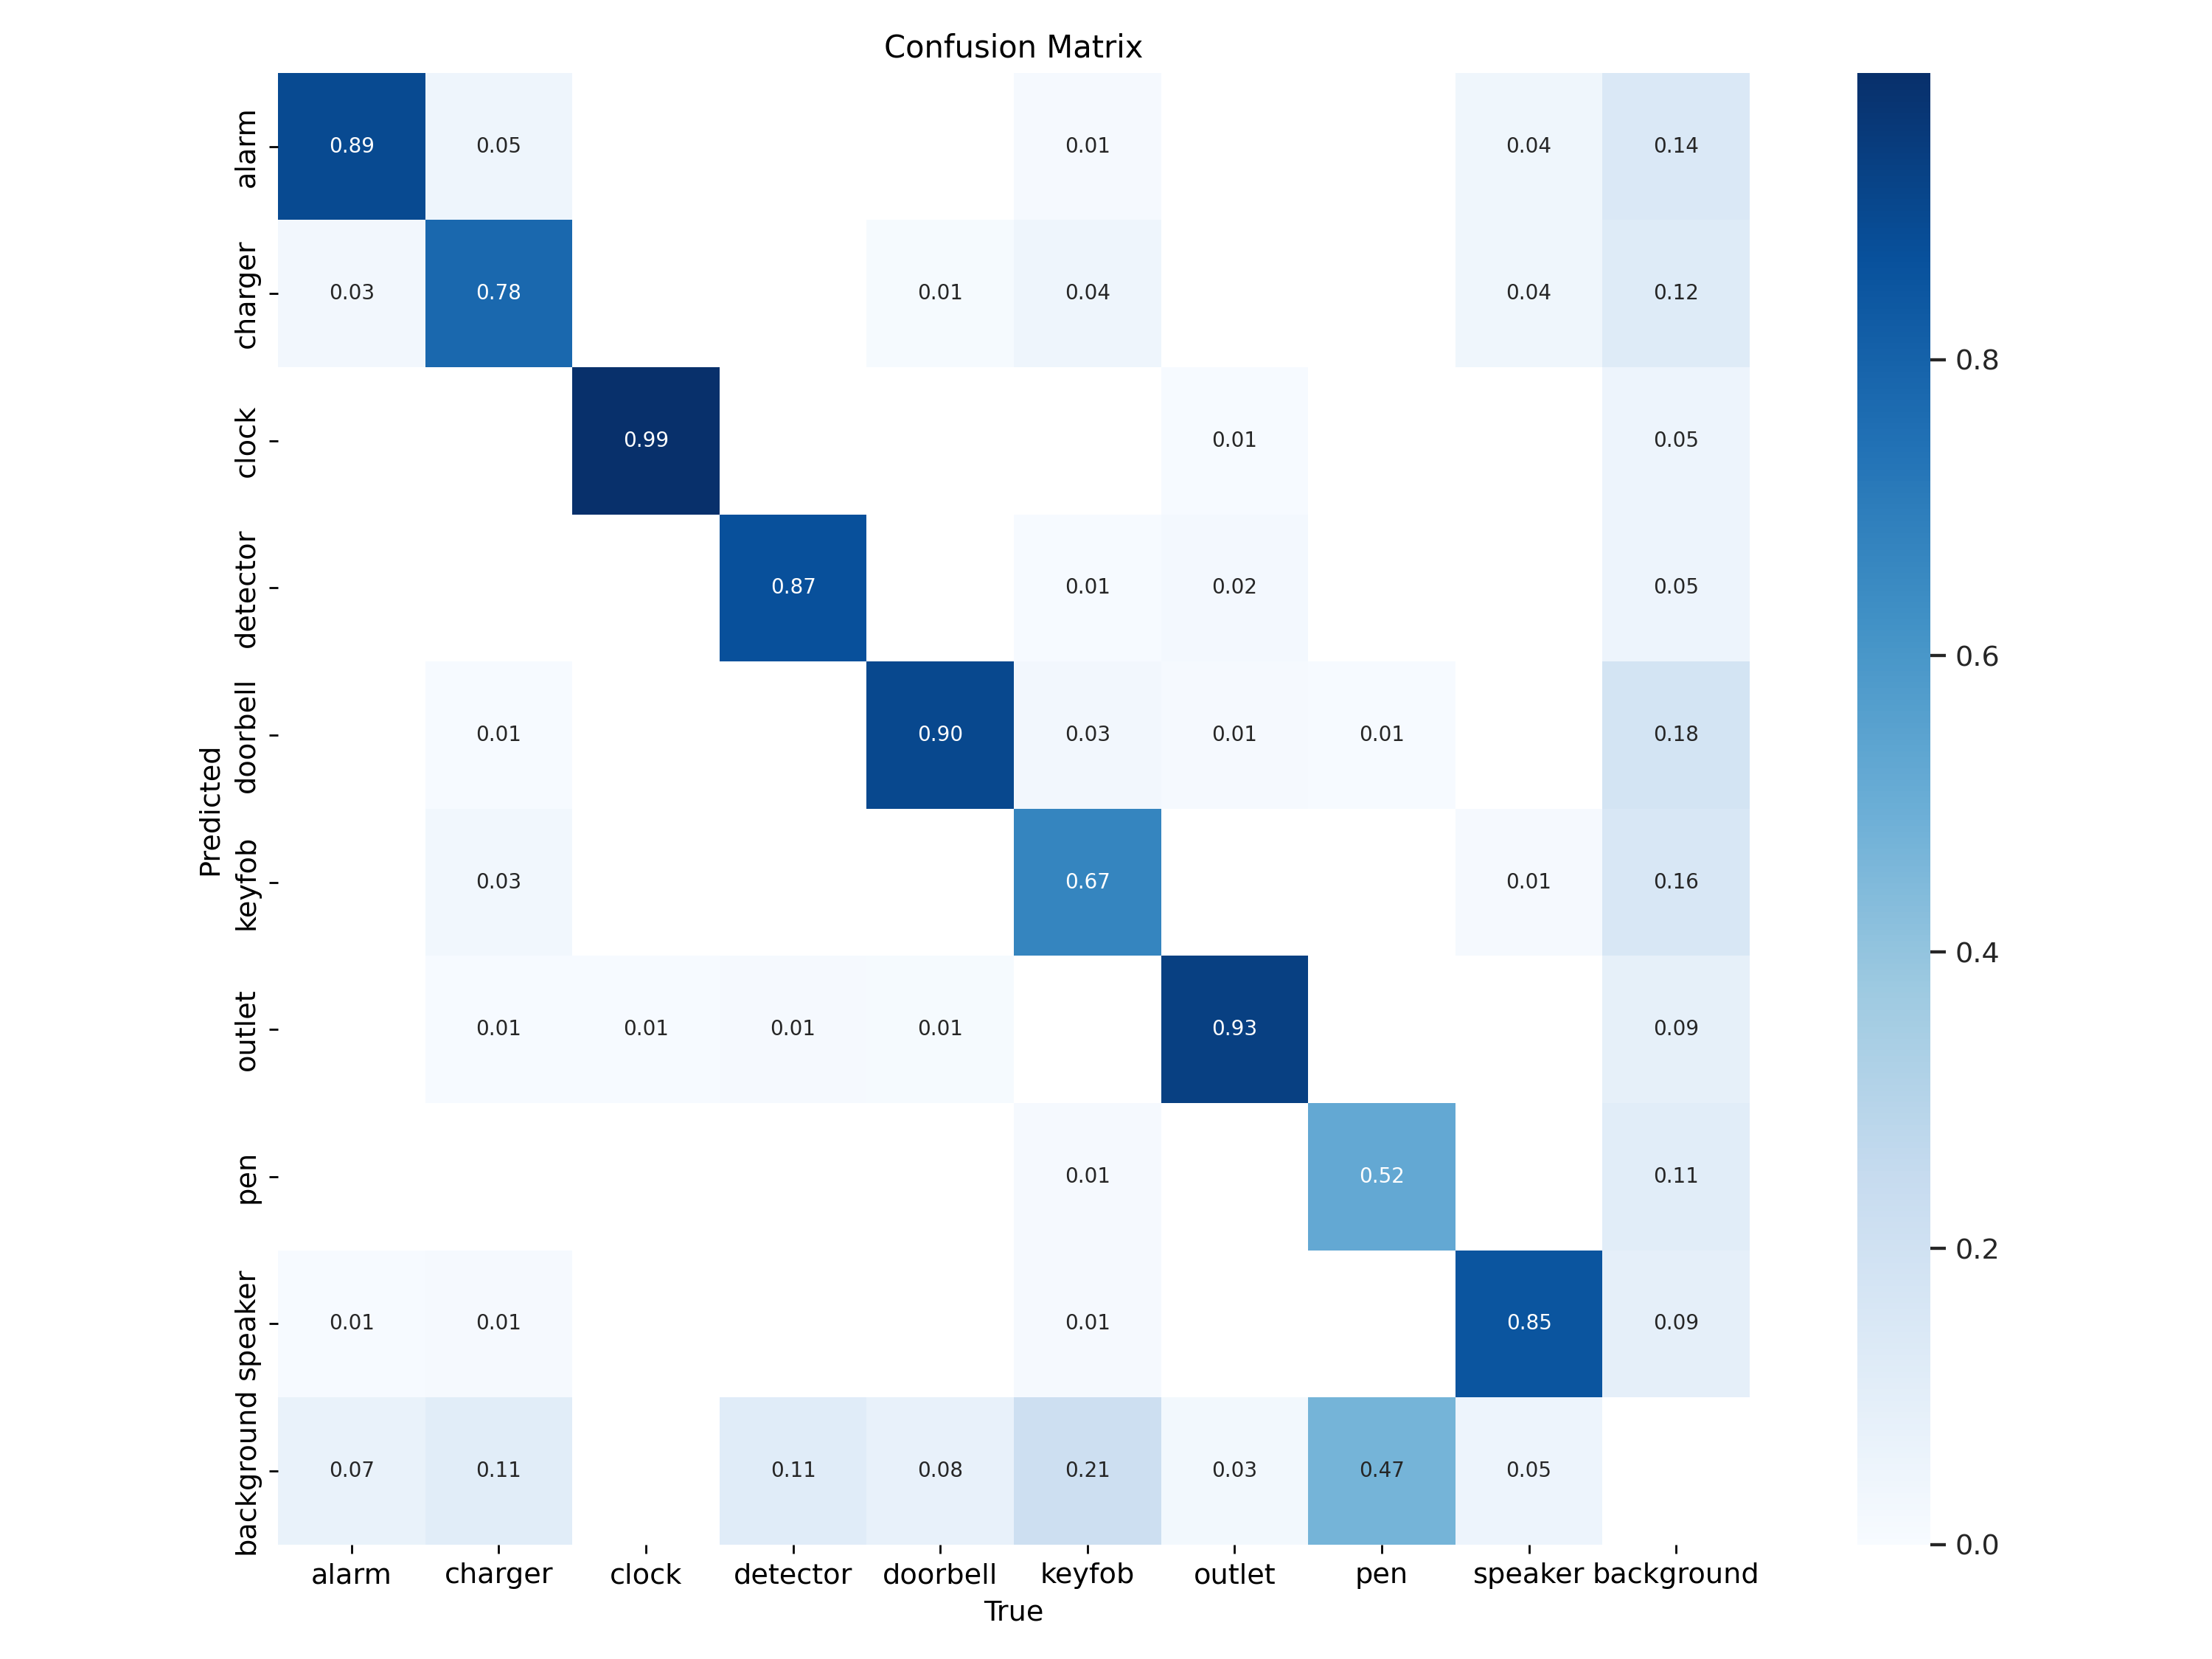

In [ ]:
# confusion matrix
Image(filename='/content/yolov5/runs/train/exp2/confusion_matrix.png', width=1200)

In [ ]:
!python detect.py --weights runs/train/exp2/weights/best.pt --img 640 --source /content/dataset/valid/images
clear_output()

In [ ]:
def plot_results(dir_result, images_list, n_rows, n_cols, height, width, start = 1):
  
  indices=np.arange(start, n_rows*n_cols+start).reshape(n_rows, n_cols)
  fig, ax = plt.subplots(n_rows, n_cols, figsize=(height, width))
  for i in range(n_rows):
    for j in range(n_cols):
      index=indices[i,j]
      im = cv2.imread(dir_result+list_result_images[index])
      im1 =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      ax[i,j].imshow(im1) 
      ax[i,j].get_xaxis().set_visible(False) 
      ax[i,j].get_yaxis().set_visible(False)
      ax[i,j].set_title("#"+str(index)) 

Всего картинок в тестовой выборке: 200


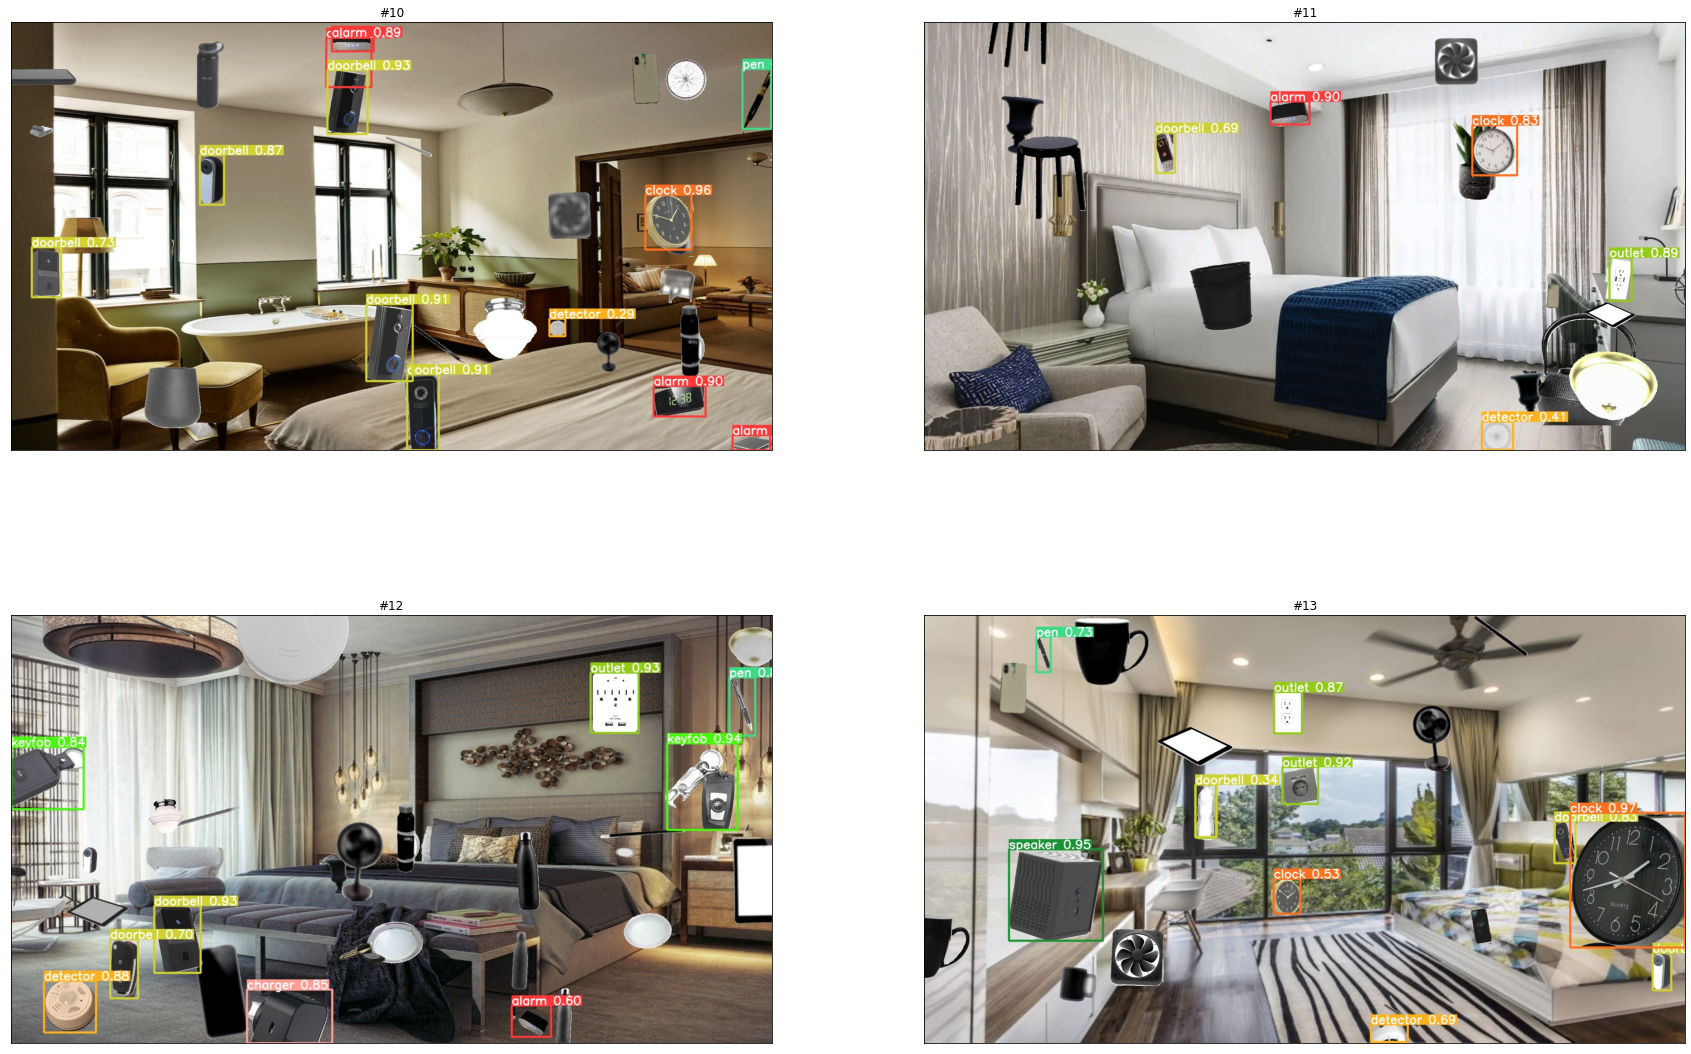

In [ ]:
dir_result = '/content/yolov5/runs/detect/exp4/'
list_result_images = os.listdir(dir_result)
n_result = len(list_result_images)
print("Всего картинок в тестовой выборке:", n_result)
plot_results(dir_result, list_result_images, 2, 2, 30, 20, start = 10)

In [ ]:
!zip -r /content/dataset.zip /content/dataset/
clear_output()

In [ ]:
from google.colab import files
files.download('/content/dataset.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('content/yolov5/runs/train/exp2/weights/best.pt')